## Notebook for Loading Models and Visualizing Results on Data

#### Note: temp, will integrate into python file for when working with large dataset

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from ml_suite.models.conv_AE import ConvolutionalAutoencoder
from ml_suite.data.dataset import get_dataset

##### Paths, Variables, and Device

In [2]:
data_dir = "/scratch/pdy2bw/ml_suite_data/datasets/turbulent_radiative_layer_2D/data/test"
weights_dir = "results/phys_test_multiGPU_normalized/latest.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

Device: cpu


##### Get Test Data

In [3]:
dataset = get_dataset(data_dir=data_dir)

print(f"Number of test data samples: {len(dataset)}")

x, _ = dataset[0]
print(f"Data Shape: {x.shape}")

Number of test data samples: 900
Data Shape: torch.Size([4, 128, 384])


##### Load Model and Weights

In [ ]:
import torch
from collections import OrderedDict

def safe_load_state_dict(model, checkpoint_path, key="model_state_dict", map_location="cpu"):
    """
    Safely load a model checkpoint, handling DDP/DataParallel prefixes and mismatched keys.
    
    Args:
        model (torch.nn.Module): Model to load weights into.
        checkpoint_path (str or Path): Path to the checkpoint file (.pt or .pth).
        key (str): The key containing the state_dict (default: 'model_state_dict').
        map_location (str): Device map for loading (default: 'cpu').

    Returns:
        model (torch.nn.Module): Model with weights loaded.
    """
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    
    # If checkpoint is just the state_dict, not a dict with keys
    if isinstance(checkpoint, dict) and key in checkpoint:
        state_dict = checkpoint[key]
    else:
        state_dict = checkpoint
    
    # Handle DataParallel or DDP "module." prefix
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[new_key] = v

    # Try loading strictly first
    try:
        model.load_state_dict(new_state_dict, strict=True)
        print(f"✅ Successfully loaded state_dict (strict=True) from {checkpoint_path}")
    except RuntimeError as e:
        print(f"⚠️ Warning: {e}")
        print("Attempting to load with strict=False...")
        missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
        if missing:
            print(f"⚠️ Missing keys: {missing}")
        if unexpected:
            print(f"⚠️ Unexpected keys: {unexpected}")
        print(f"✅ Loaded with strict=False from {checkpoint_path}")

    return model


In [12]:
layers = [4, 8]
latent_dim = 8
act_fn = nn.ReLU()
final_act_fn = nn.Identity()

model = ConvolutionalAutoencoder(layers=layers, latent_dim=latent_dim, act_fn=act_fn, final_act_fn=final_act_fn).to(device)

model = safe_load_state_dict(model, weights_dir)
model.eval()

# method below can't handle weights trained with multi GPU directly
# checkpoint = torch.load(weights_dir, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

✅ Successfully loaded state_dict (strict=True) from results/phys_test_multiGPU_normalized/latest.pt


ConvolutionalAutoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Identity()
    )
  )
)

##### Run Inference

In [13]:
num_images = 10
ground_truth = []
reconstructions = []

with torch.no_grad():
    for i in range(num_images):
        x, _ = dataset[10*i + 8]
        x = x.unsqueeze(0).to(device)  # add batch dimension and move to device

        output = model(x)           
        output = output.squeeze(0).cpu()  

        ground_truth.append(x.squeeze(0).cpu())
        reconstructions.append(output)

In [31]:
import matplotlib.pyplot as plt

def plot_ground_truth_vs_recon(ground_truth, reconstructions, num_images=5):
    num_images = min(num_images, len(ground_truth))
    num_channels = ground_truth[0].shape[0]

    for i in range(num_images):
        gt = ground_truth[i]
        recon = reconstructions[i]

        fig, axes = plt.subplots(2, num_channels, figsize=(3*num_channels, 6))
        fig.suptitle(f"Sample {i}", fontsize=14)

        for c in range(num_channels):
            # Ground truth
            im_gt = axes[0, c].imshow(
                gt[c].detach().cpu(), cmap="jet", aspect='equal'
            )
            axes[0, c].set_title(f"GT - Channel {c}")
            axes[0, c].axis("off")
            fig.colorbar(im_gt, ax=axes[0, c], fraction=0.046, pad=0.04)

            # Reconstruction
            im_recon = axes[1, c].imshow(
                recon[c].detach().cpu(), cmap="jet", aspect='equal'
            )
            axes[1, c].set_title(f"Recon - Channel {c}")
            axes[1, c].axis("off")
            fig.colorbar(im_recon, ax=axes[1, c], fraction=0.046, pad=0.04)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



In [33]:
import matplotlib.pyplot as plt
import torch

def plot_ground_truth_vs_recon(ground_truth, reconstructions, num_images=5):
    num_images = min(num_images, len(ground_truth))
    num_channels = ground_truth[0].shape[0]

    for i in range(num_images):
        gt = ground_truth[i]
        recon = reconstructions[i]

        fig, axes = plt.subplots(2, num_channels, figsize=(3*num_channels, 6))
        fig.suptitle(f"Sample {i}", fontsize=14)

        for c in range(num_channels):
            # Determine shared min/max for this channel
            channel_min = min(gt[c].min().item(), recon[c].min().item())
            channel_max = max(gt[c].max().item(), recon[c].max().item())

            # Ground truth
            im_gt = axes[0, c].imshow(
                gt[c].detach().cpu(), cmap="jet", aspect='equal',
                vmin=channel_min, vmax=channel_max
            )
            axes[0, c].set_title(f"GT - Channel {c}")
            axes[0, c].axis("off")
            fig.colorbar(im_gt, ax=axes[0, c], fraction=0.046, pad=0.04)

            # Reconstruction
            im_recon = axes[1, c].imshow(
                recon[c].detach().cpu(), cmap="jet", aspect='equal',
                vmin=channel_min, vmax=channel_max
            )
            axes[1, c].set_title(f"Recon - Channel {c}")
            axes[1, c].axis("off")
            fig.colorbar(im_recon, ax=axes[1, c], fraction=0.046, pad=0.04)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


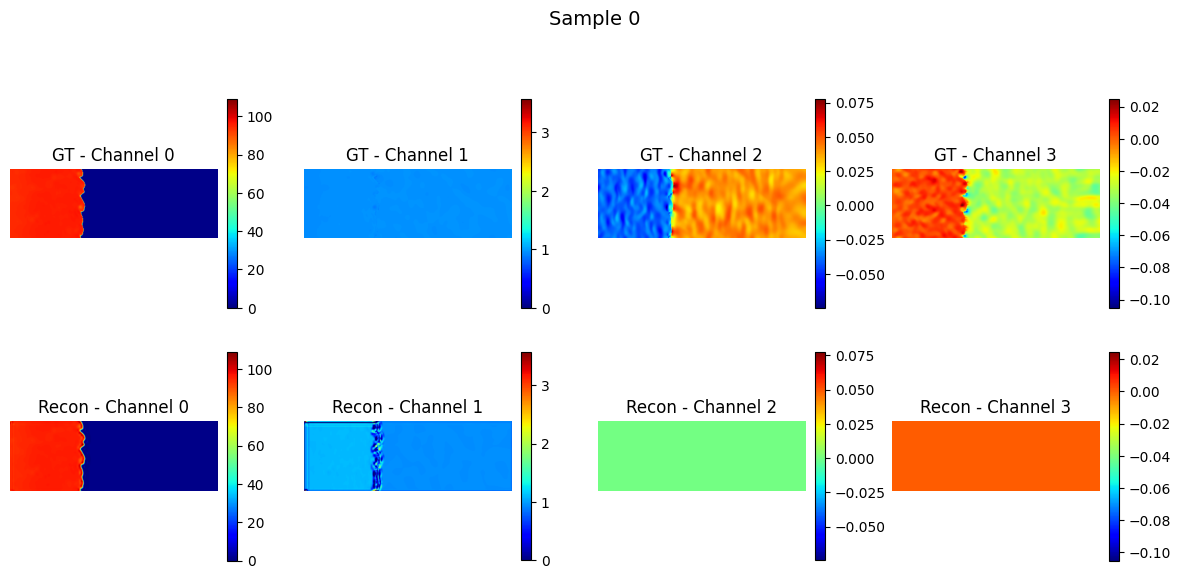

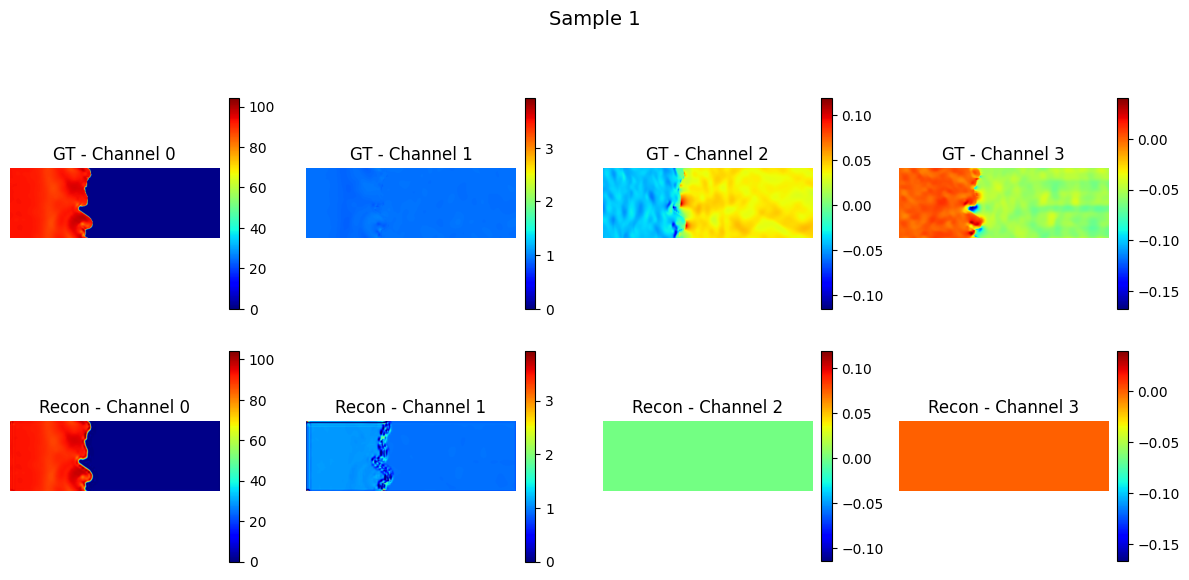

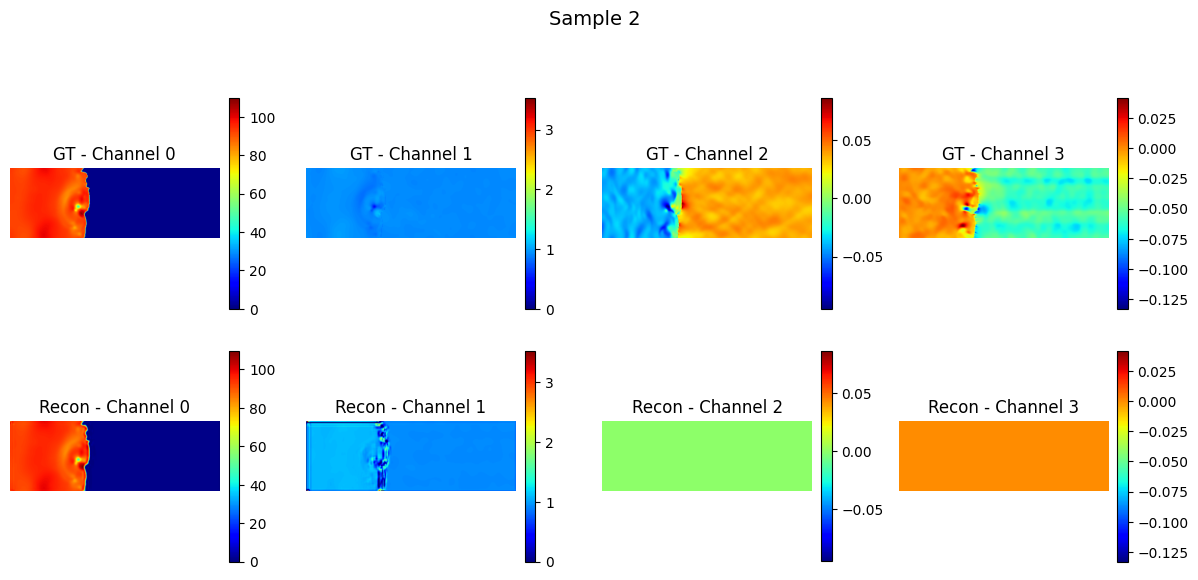

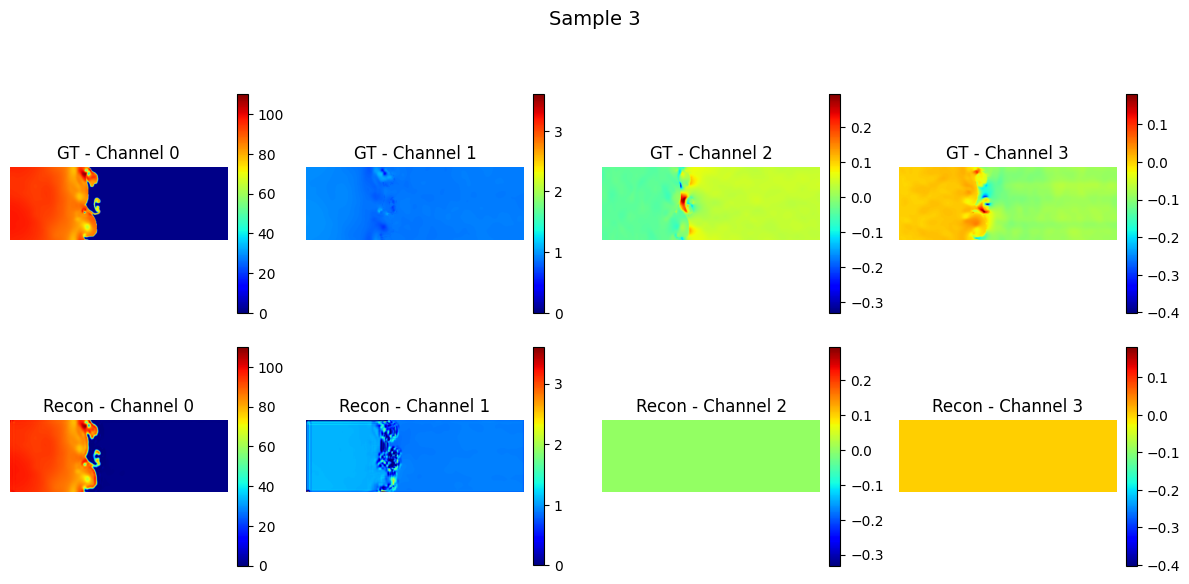

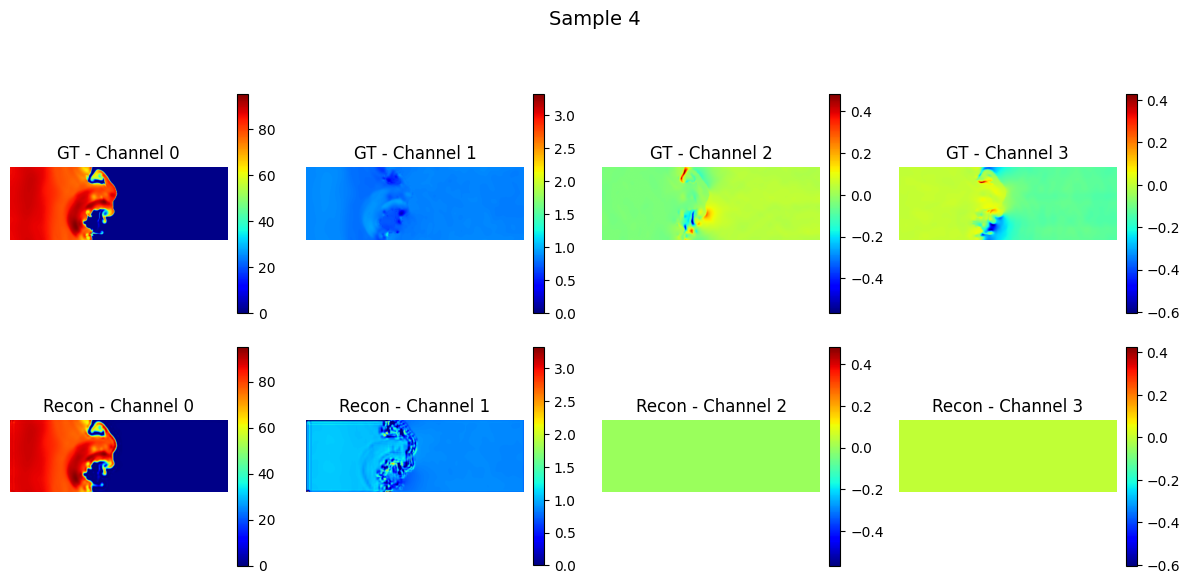

In [34]:
plot_ground_truth_vs_recon(ground_truth, reconstructions, num_images=5)
